**`Background:`**

We are one of the fastest growing startups in the logistics and delivery domain. We work with several partners and make on-demand delivery to our customers. During the COVID-19 pandemic, we are facing several different challenges and everyday we are trying to address these challenges.

We thrive on making our customers happy. As a growing startup, with a global expansion strategy we know that we need to make our customers happy and the only way to do that is to measure how happy each customer is. If we can predict what makes our customers happy or unhappy, we can then take necessary actions.

Getting feedback from customers is not easy either, but we do our best to get constant feedback from our customers. This is a crucial function to improve our operations across all levels.

We recently did a survey to a select customer cohort. You are presented with a subset of this data. We will be using the remaining data as a private test set.

**`Data Description:`**

**Y** = target attribute (Y) with values indicating 0 (unhappy) and 1 (happy) customers <br/>
**X1** = my order was delivered on time <br/>
**X2** = contents of my order was as I expected <br/>
**X3** = I ordered everything I wanted to order <br/>
**X4** = I paid a good price for my order <br/>
**X5** = I am satisfied with my courier <br/>
**X6** = the app makes ordering easy for me

Attributes X1 to X6 indicate the responses for each question and have values from 1 to 5 where the smaller number indicates less and the higher number indicates more towards the answer.

**`Download Data:`**

https://drive.google.com/open?id=1KWE3J0uU_sFIJnZ74Id3FDBcejELI7FD

**`Goal(s):`**

Predict if a customer is happy or not based on the answers they give to questions asked.

**`Success Metrics:`**

1. Reach 73% accuracy score or above, or convince us why your solution is superior. We are definitely interested in every solution and insight you can provide us.

2. Try to submit your working solution as soon as possible. The sooner the better.

**`Bonus(es):`**

We are very interested in finding which questions/features are more important when predicting a customer’s happiness. Using a feature selection approach show us understand what is the minimal set of attributes/features that would preserve the most information about the problem while increasing predictability of the data we have. Is there any question that we can remove in our next survey?

**`Submission Instructions:`**

Project should be implemented with Python
Please name your repository on GitHub with this name without exposing your project information: 2dpXp5tSdBTsdds9

## Table Of Contents:
* [Importing Libraries](#imp-libraries)
* [Data Analysis](#data-analysis)
   * [Univariate + Bivariate Analysis](#uni-bi-analysis)
* [Model Fitting (Grid Search SVC)](#model-fitting)
* [XGBOOST Model (Grid Search)](#xgboost-grid)
* [XGBOOST Model (Without Grid Search)](#xgboost-no-grid)
    * [XGBOOST Model (SHAP Values)](#xgboost-shap)
    * [SHAP Dependence Contribution Plots](#xgboost-shap-plot)
* [Light GBM](#lgbm)
    * [LGBM SHAP Values](#lgbm-shap)
* [CatBoost GBM](#catboost)
    * [CatBoost SHAP Values](#cat-shap)
* [Feature Selection via RFECV (Recursive Feature Elimination CV)](#rfecv)
* [Final Model on selected features](#final)
* [Conclusion](#conclusion)

### Importing Libraries <a class="anchor" id="imp-libraries"></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings("ignore")
import shap

In [2]:
df = pd.read_csv('./ACME-HappinessSurvey2020.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Y       126 non-null    int64
 1   X1      126 non-null    int64
 2   X2      126 non-null    int64
 3   X3      126 non-null    int64
 4   X4      126 non-null    int64
 5   X5      126 non-null    int64
 6   X6      126 non-null    int64
dtypes: int64(7)
memory usage: 7.0 KB


In [4]:
df.describe()

,Y,X1,X2,X3,X4,X5,X6
count,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000
mean,0.547619,4.333333,2.531746,3.309524,3.746032,3.650794,4.253968
std,0.499714,0.800000,1.114892,1.023440,0.875776,1.147641,0.809311
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,4.000000,2.000000,3.000000,3.000000,3.000000,4.000000
50%,1.000000,5.000000,3.000000,3.000000,4.000000,4.000000,4.000000
75%,1.000000,5.000000,3.000000,4.000000,4.000000,4.000000,5.000000
max,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [5]:
df.head()

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


In [6]:
df['Y'].value_counts()

1    69
0    57
Name: Y, dtype: int64

### Data Analysis <a class="anchor" id="data-analysis"></a>

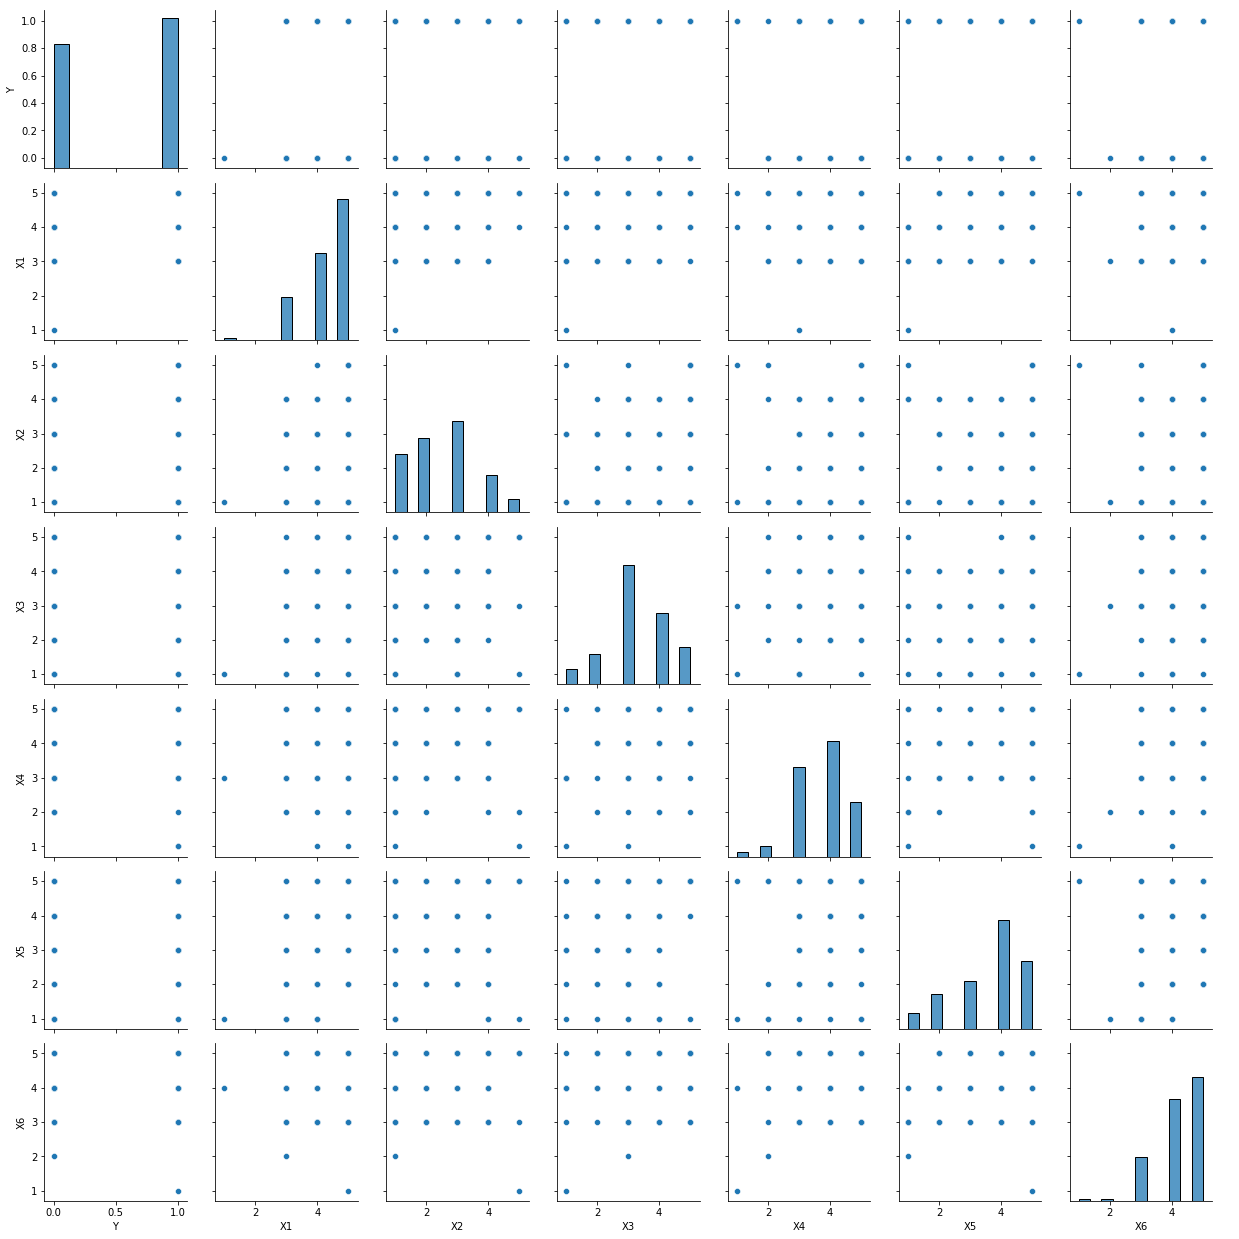

In [7]:
sns.pairplot(df)

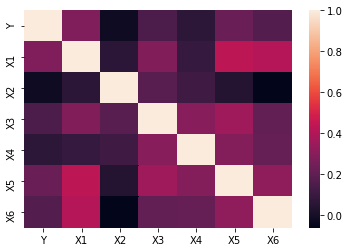

In [8]:
sns.heatmap(df.corr())

In [9]:
train_X, test_X, train_y, test_y = train_test_split(df.drop(['Y'], axis=1), df['Y'], random_state=42, stratify=df['Y'])

In [10]:
print("Train dataset shape is: ", train_X.shape, train_y.shape)
print("Train dataset shape is: ", test_X.shape, test_y.shape)

Train dataset shape is:  (94, 6) (94,)
Train dataset shape is:  (32, 6) (32,)


### Univariate + Bivariate Analysis <a class="anchor" id="uni-bi-analysis"></a>

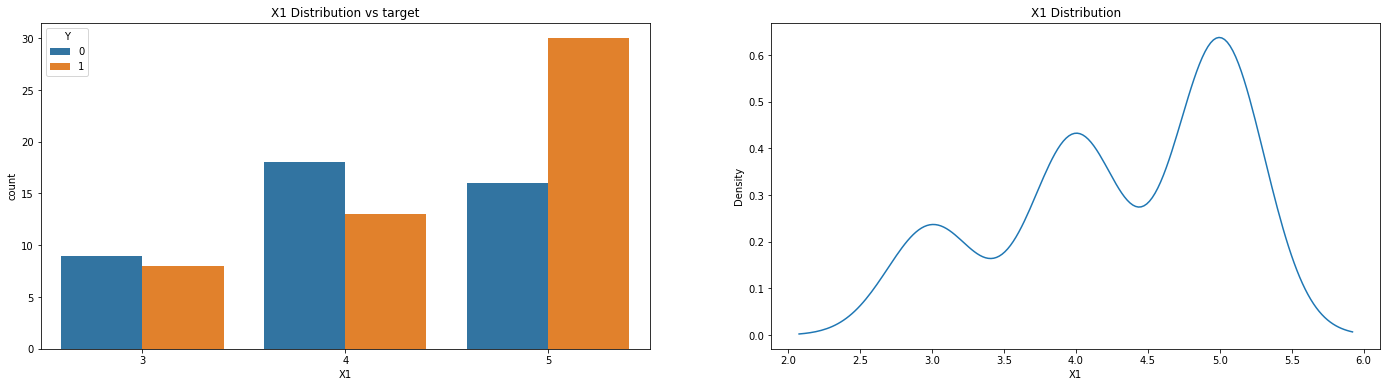

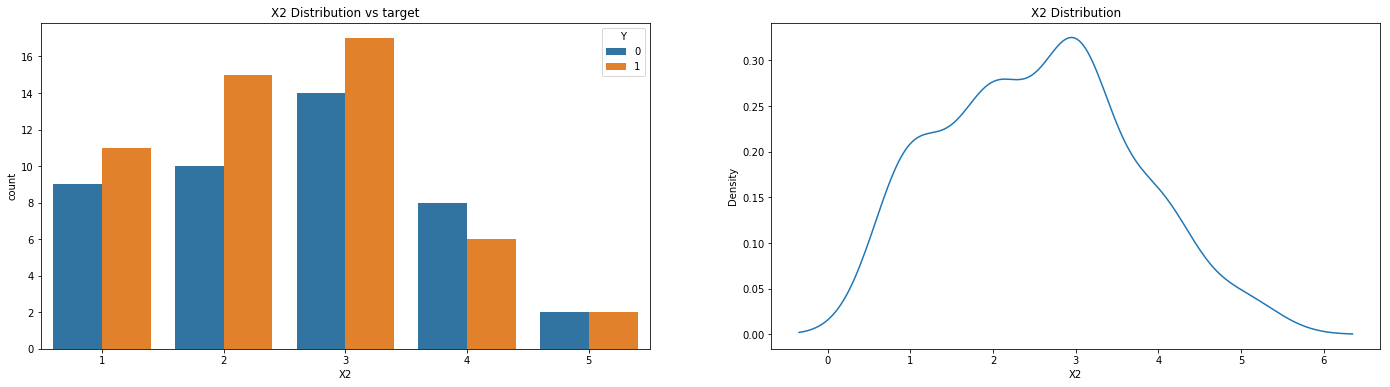

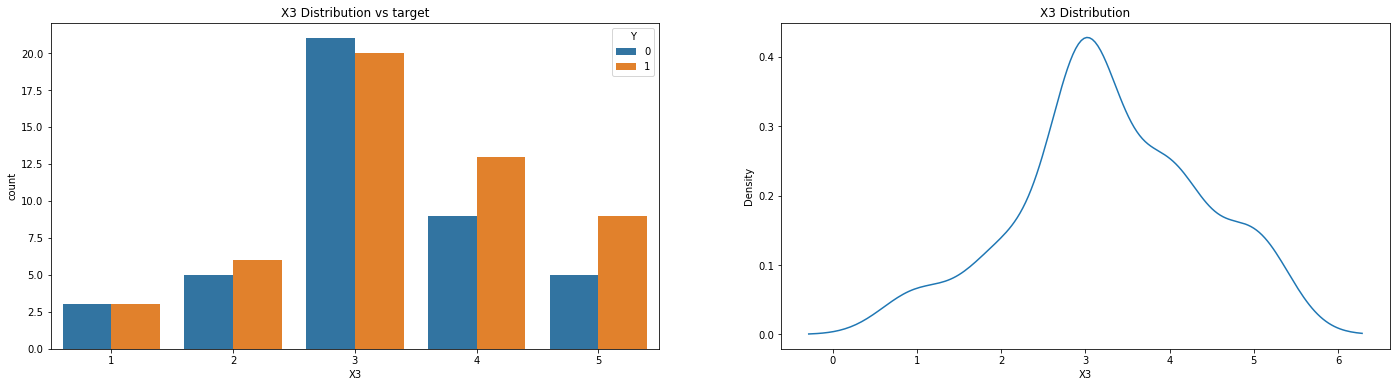

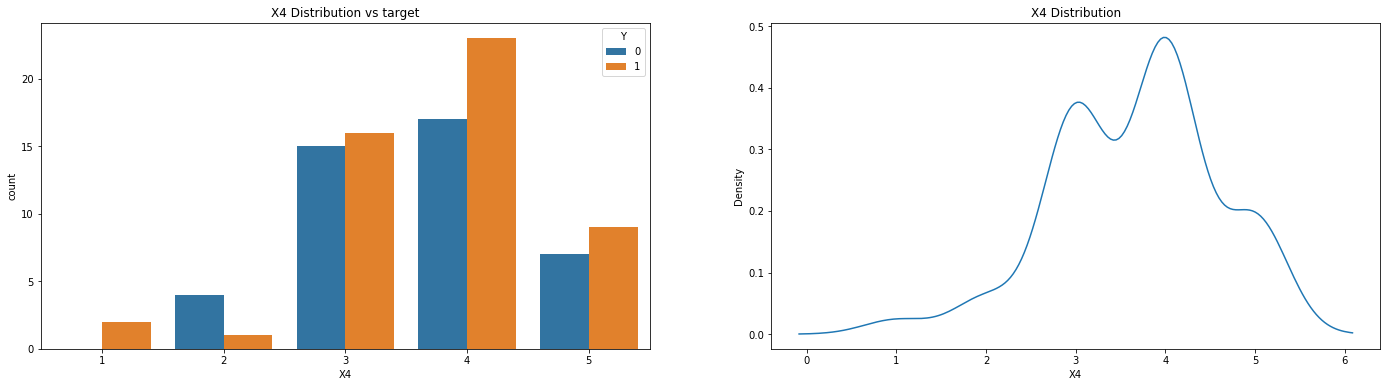

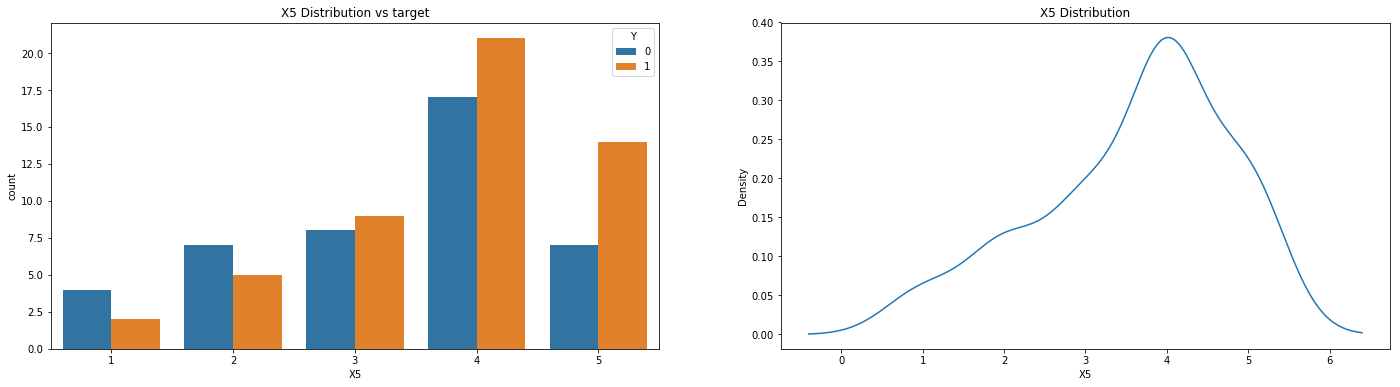

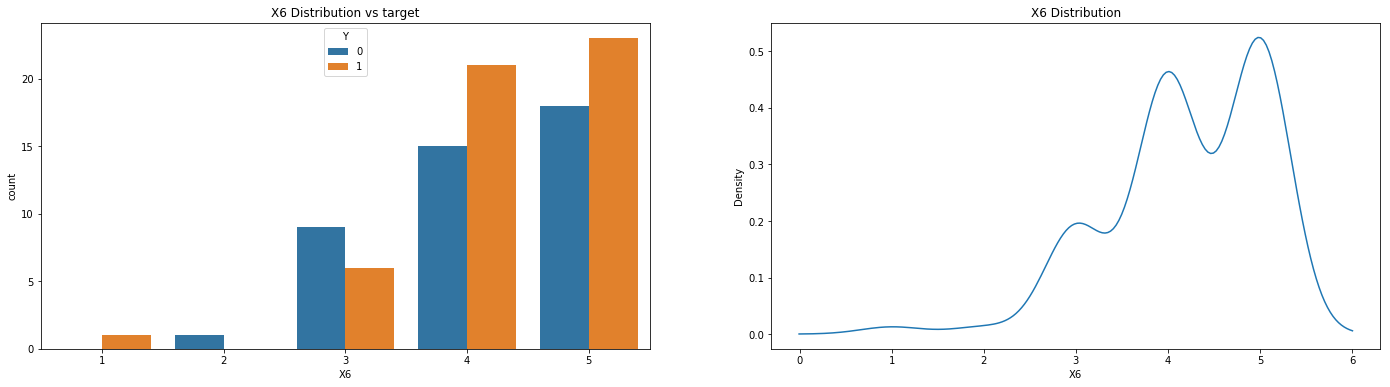

In [11]:
for i,feature in enumerate(train_X.columns):
    fig, axes = plt.subplots(ncols=2, figsize=(24, 6))
    
    sns.countplot(data=train_X, x=feature, hue=train_y, ax=axes[0])
    axes[0].set_title(f"{feature} Distribution vs target")

    sns.kdeplot(data=train_X[feature], ax=axes[1])
    axes[1].set_title(f"{feature} Distribution")

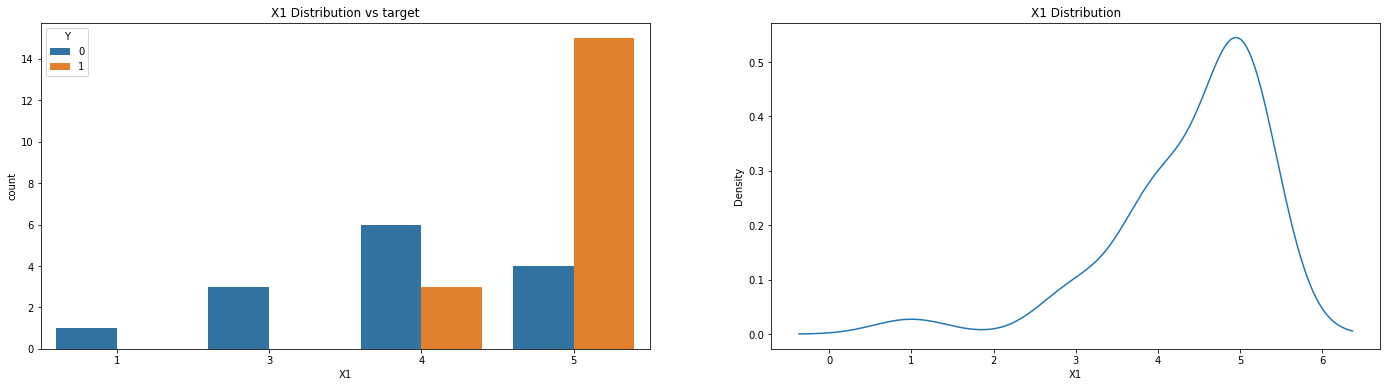

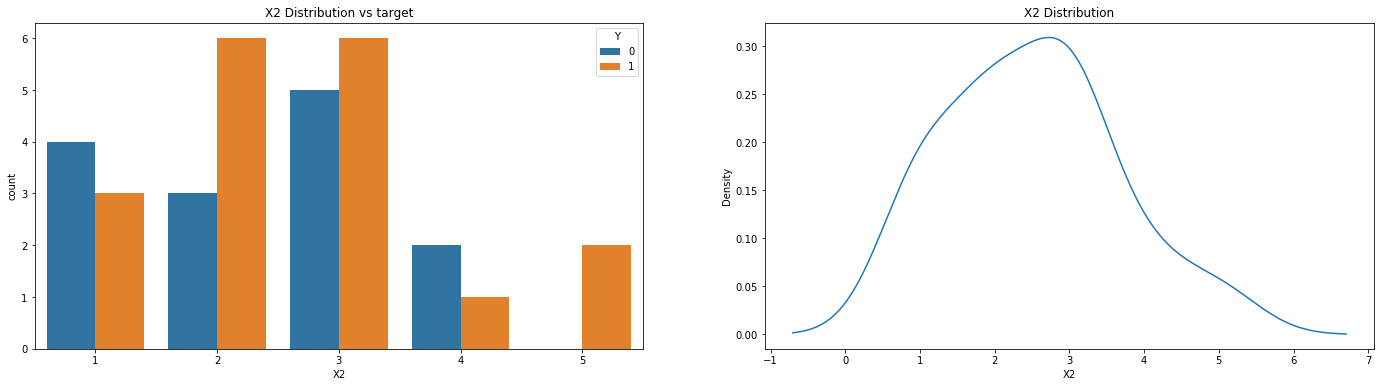

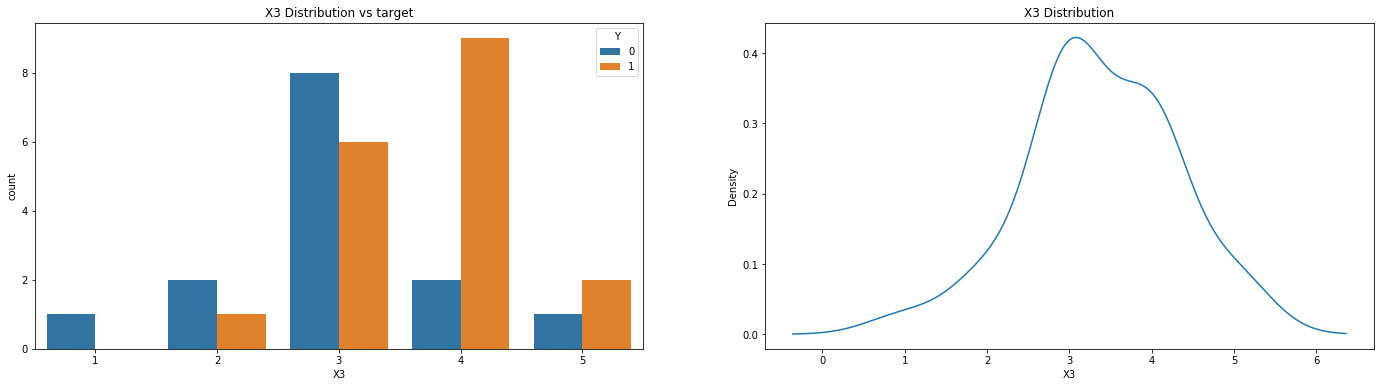

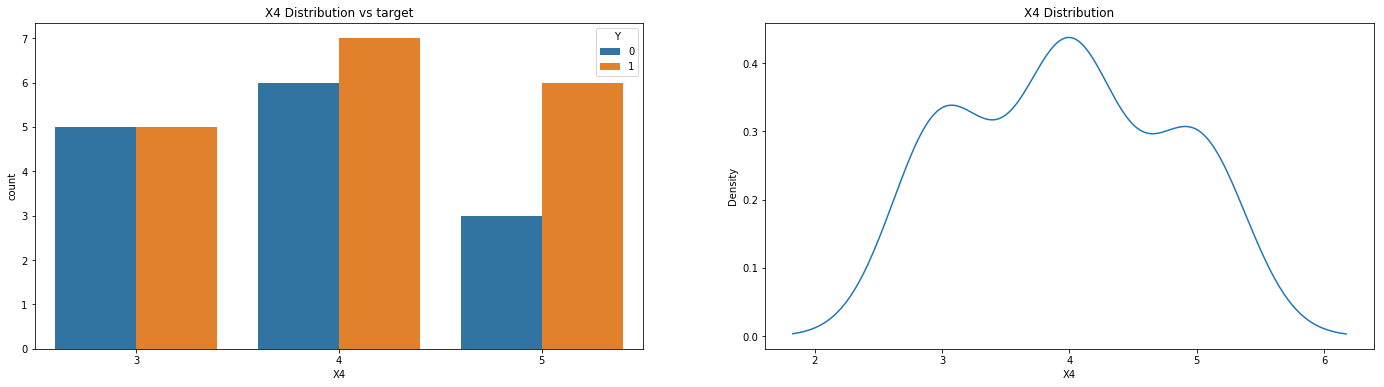

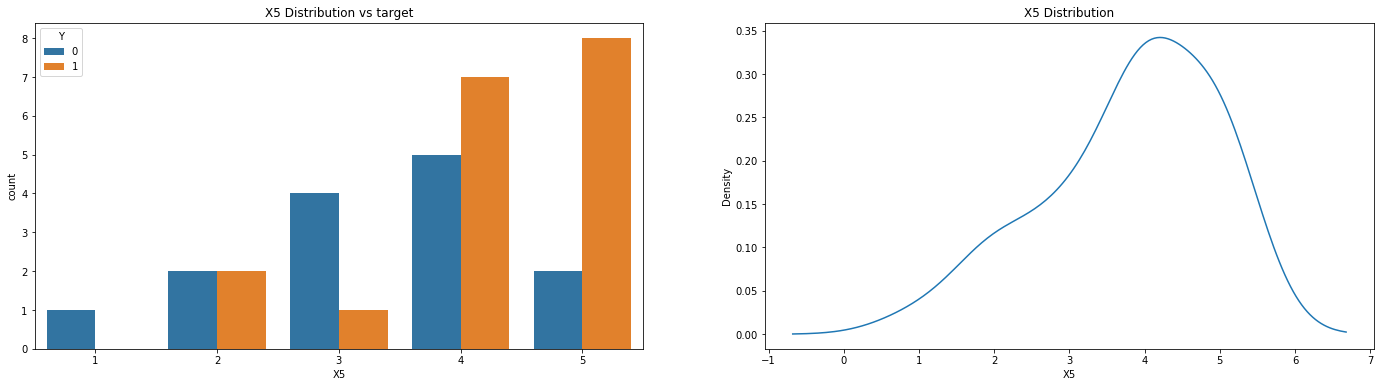

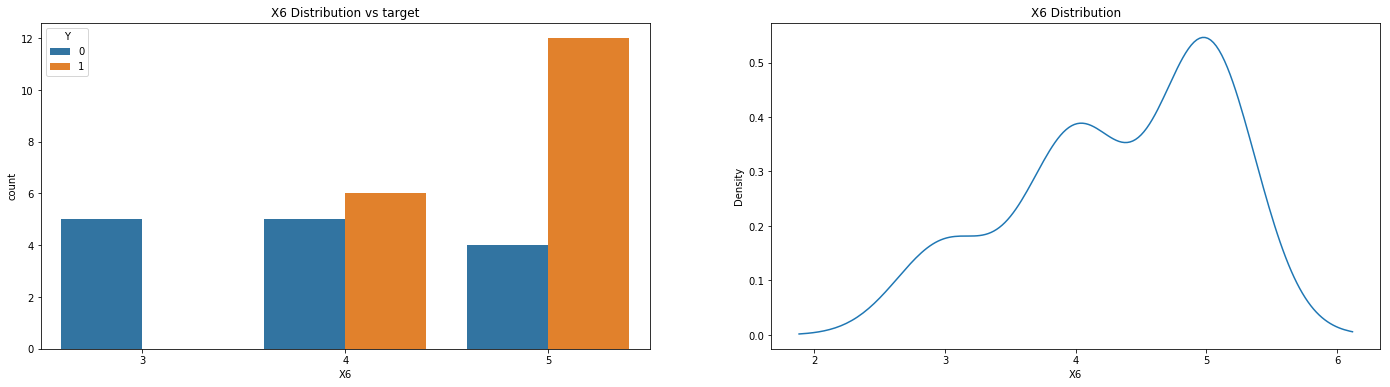

In [12]:
for i,feature in enumerate(test_X.columns):
    fig, axes = plt.subplots(ncols=2, figsize=(24, 6))
    
    sns.countplot(data=test_X, x=feature, hue=test_y, ax=axes[0])
    axes[0].set_title(f"{feature} Distribution vs target")

    sns.kdeplot(data=test_X[feature], ax=axes[1])
    axes[1].set_title(f"{feature} Distribution")

Text(0, 0.5, 'Explained Variance')

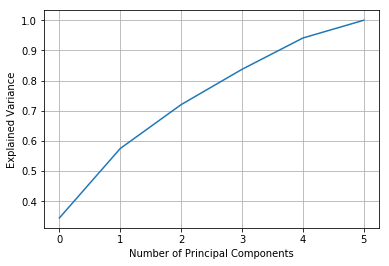

In [13]:
pca = PCA()
comp = pca.fit(train_X)

plt.plot(np.cumsum(comp.explained_variance_ratio_))
plt.grid()
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance')

### Model Fitting (Grid Search SVC)  <a class="anchor" id="model-fitting"></a>

In [14]:
svc_clf =  SVC(kernel='poly')

param_grid_forest = [ 
        {'n_estimators': [30, 50, 70, 100],
         'criterion': ['entropy', 'gini'], 
         'max_depth': range(1,10)
        }
    ]

param_grid_logr=[
        {'C': np.logspace(-3,3,7), 
         'penalty': ['l1','l2']
        }
    ]

param_grid_svc = [
        {'C': [1, 10, 50, 100],
         'degree': range(2,5)
        }
    ]

gs_cv = GridSearchCV(estimator=svc_clf,
            param_grid=param_grid_svc,
            scoring='accuracy',
            cv=5, verbose=2, return_train_score = True)

In [15]:
# Fit using grid search
gs_cv.fit(train_X, train_y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ......................................C=1, degree=2; total time=   0.0s
[CV] END ......................................C=1, degree=2; total time=   0.0s
[CV] END ......................................C=1, degree=2; total time=   0.0s
[CV] END ......................................C=1, degree=2; total time=   0.0s
[CV] END ......................................C=1, degree=2; total time=   0.0s
[CV] END ......................................C=1, degree=3; total time=   0.0s
[CV] END ......................................C=1, degree=3; total time=   0.0s
[CV] END ......................................C=1, degree=3; total time=   0.0s
[CV] END ......................................C=1, degree=3; total time=   0.0s
[CV] END ......................................C=1, degree=3; total time=   0.0s
[CV] END ......................................C=1, degree=4; total time=   0.1s
[CV] END ......................................C

GridSearchCV(cv=5, estimator=SVC(kernel='poly'),
             param_grid=[{'C': [1, 10, 50, 100], 'degree': range(2, 5)}],
             return_train_score=True, scoring='accuracy', verbose=2)

In [16]:
# Best accuracy
print('Best accuracy: %.3f' % gs_cv.best_score_)
# Best params
print('\nBest params:\n', gs_cv.best_params_)

pred_y = gs_cv.predict(test_X)

Best accuracy: 0.605

Best params:
 {'C': 1, 'degree': 3}


In [17]:
# Metric calculation function. Different classification metrics are being caluclated here.

def metric_calculation(test_y, pred_y):
    acc = accuracy_score(test_y, pred_y)
    print("The accuracy is {}".format(acc))

    prec = precision_score(test_y, pred_y)
    print("The precision is {}".format(prec))

    rec = recall_score(test_y, pred_y)
    print("The recall is {}".format(rec))

    f1 = f1_score(test_y, pred_y)
    print("The F1-Score is {}".format(f1))
    
    print(classification_report(test_y, pred_y))
    
    LABELS=['0', '1']
    conf_matrix=confusion_matrix(test_y, pred_y)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
    plt.title("Happy Customer")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()

The accuracy is 0.59375
The precision is 0.6190476190476191
The recall is 0.7222222222222222
The F1-Score is 0.6666666666666666
              precision    recall  f1-score   support

           0       0.55      0.43      0.48        14
           1       0.62      0.72      0.67        18

    accuracy                           0.59        32
   macro avg       0.58      0.58      0.57        32
weighted avg       0.59      0.59      0.58        32



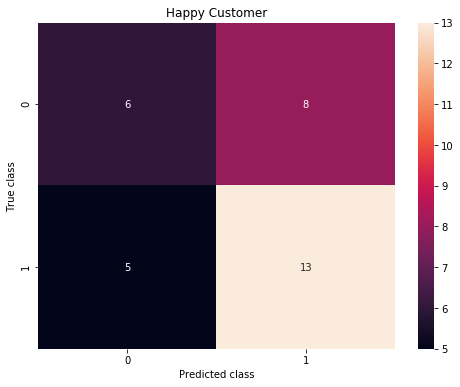

In [18]:
metric_calculation(test_y, pred_y)

## XGBOOST Model (Grid Search) <a class="anchor" id="xgboost-grid"></a>

In [19]:
param_grid_xgb = param_grid_xgb=[
        {'max_depth': [3, 6, 10, 15],
         'learning_rate': [0.01, 0.05, 0.1, 0.5],
         'n_estimators': [50, 100, 200],
         'colsample_bytree': [0.3, 0.7, 0.9],
         'objective': ['binary:logistic']
        }
    ]

In [20]:
xgb_clf = XGBClassifier(eval_metric='logloss')

gs_cv_xgb = GridSearchCV(estimator=xgb_clf,
            param_grid=param_grid_xgb,
            scoring='accuracy',
            cv=5, verbose=2, return_train_score = True)

In [21]:
gs_cv_xgb.fit(train_X, train_y)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=50, objective=binary:logistic; total time=   0.0s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=50, objective=binary:logistic; total time=   0.0s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=50, objective=binary:logistic; total time=   0.0s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=50, objective=binary:logistic; total time=   0.0s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=50, objective=binary:logistic; total time=   0.0s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100, objective=binary:logistic; total time=   0.0s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100, objective=binary:logistic; total time=   0.0s
[CV] END colsample_bytree=0.3, learning_rate=0

[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=3, n_estimators=100, objective=binary:logistic; total time=   0.2s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=3, n_estimators=100, objective=binary:logistic; total time=   0.1s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=3, n_estimators=100, objective=binary:logistic; total time=   0.1s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=3, n_estimators=100, objective=binary:logistic; total time=   0.1s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=3, n_estimators=100, objective=binary:logistic; total time=   0.1s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=3, n_estimators=200, objective=binary:logistic; total time=   0.2s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=3, n_estimators=200, objective=binary:logistic; total time=   0.2s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=3, n_estimators=200, objective=binary:logis

[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, n_estimators=100, objective=binary:logistic; total time=   0.0s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, n_estimators=200, objective=binary:logistic; total time=   0.1s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, n_estimators=200, objective=binary:logistic; total time=   0.1s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, n_estimators=200, objective=binary:logistic; total time=   0.1s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, n_estimators=200, objective=binary:logistic; total time=   0.2s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, n_estimators=200, objective=binary:logistic; total time=   0.2s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=50, objective=binary:logistic; total time=   0.0s
[CV] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=50, objective=binary:logistic; total

[CV] END colsample_bytree=0.3, learning_rate=0.5, max_depth=3, n_estimators=200, objective=binary:logistic; total time=   0.1s
[CV] END colsample_bytree=0.3, learning_rate=0.5, max_depth=6, n_estimators=50, objective=binary:logistic; total time=   0.0s
[CV] END colsample_bytree=0.3, learning_rate=0.5, max_depth=6, n_estimators=50, objective=binary:logistic; total time=   0.0s
[CV] END colsample_bytree=0.3, learning_rate=0.5, max_depth=6, n_estimators=50, objective=binary:logistic; total time=   0.0s
[CV] END colsample_bytree=0.3, learning_rate=0.5, max_depth=6, n_estimators=50, objective=binary:logistic; total time=   0.0s
[CV] END colsample_bytree=0.3, learning_rate=0.5, max_depth=6, n_estimators=50, objective=binary:logistic; total time=   0.0s
[CV] END colsample_bytree=0.3, learning_rate=0.5, max_depth=6, n_estimators=100, objective=binary:logistic; total time=   0.0s
[CV] END colsample_bytree=0.3, learning_rate=0.5, max_depth=6, n_estimators=100, objective=binary:logistic; total ti

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=100, objective=binary:logistic; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=100, objective=binary:logistic; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=100, objective=binary:logistic; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=100, objective=binary:logistic; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=100, objective=binary:logistic; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=200, objective=binary:logistic; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=200, objective=binary:logistic; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=200, objective=binary:logis

[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=6, n_estimators=100, objective=binary:logistic; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=6, n_estimators=200, objective=binary:logistic; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=6, n_estimators=200, objective=binary:logistic; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=6, n_estimators=200, objective=binary:logistic; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=6, n_estimators=200, objective=binary:logistic; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=6, n_estimators=200, objective=binary:logistic; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=10, n_estimators=50, objective=binary:logistic; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=10, n_estimators=50, objective=binary:logis

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, n_estimators=200, objective=binary:logistic; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=50, objective=binary:logistic; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=50, objective=binary:logistic; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=50, objective=binary:logistic; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=50, objective=binary:logistic; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=50, objective=binary:logistic; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=100, objective=binary:logistic; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=100, objective=binary:logistic; t

[CV] END colsample_bytree=0.7, learning_rate=0.5, max_depth=10, n_estimators=50, objective=binary:logistic; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.5, max_depth=10, n_estimators=100, objective=binary:logistic; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.5, max_depth=10, n_estimators=100, objective=binary:logistic; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.5, max_depth=10, n_estimators=100, objective=binary:logistic; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.5, max_depth=10, n_estimators=100, objective=binary:logistic; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.5, max_depth=10, n_estimators=100, objective=binary:logistic; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.5, max_depth=10, n_estimators=200, objective=binary:logistic; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.5, max_depth=10, n_estimators=200, objective=binary:logist

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, n_estimators=100, objective=binary:logistic; total time=   0.1s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, n_estimators=200, objective=binary:logistic; total time=   0.4s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, n_estimators=200, objective=binary:logistic; total time=   0.2s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, n_estimators=200, objective=binary:logistic; total time=   0.2s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, n_estimators=200, objective=binary:logistic; total time=   0.2s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, n_estimators=200, objective=binary:logistic; total time=   0.2s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=15, n_estimators=50, objective=binary:logistic; total time=   0.0s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=15, n_estimators=50, objective=binary

[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=10, n_estimators=200, objective=binary:logistic; total time=   0.2s
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=10, n_estimators=200, objective=binary:logistic; total time=   0.2s
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=15, n_estimators=50, objective=binary:logistic; total time=   0.0s
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=15, n_estimators=50, objective=binary:logistic; total time=   0.0s
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=15, n_estimators=50, objective=binary:logistic; total time=   0.0s
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=15, n_estimators=50, objective=binary:logistic; total time=   0.0s
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=15, n_estimators=50, objective=binary:logistic; total time=   0.0s
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=15, n_estimators=100, objective=binary:lo

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=15, n_estimators=50, objective=binary:logistic; total time=   0.0s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=15, n_estimators=50, objective=binary:logistic; total time=   0.0s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=15, n_estimators=100, objective=binary:logistic; total time=   0.1s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=15, n_estimators=100, objective=binary:logistic; total time=   0.1s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=15, n_estimators=100, objective=binary:logistic; total time=   0.1s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=15, n_estimators=100, objective=binary:logistic; total time=   0.1s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=15, n_estimators=100, objective=binary:logistic; total time=   0.1s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=15, n_estimators=200, objective=binary:logisti

[CV] END colsample_bytree=0.9, learning_rate=0.5, max_depth=15, n_estimators=100, objective=binary:logistic; total time=   0.1s
[CV] END colsample_bytree=0.9, learning_rate=0.5, max_depth=15, n_estimators=200, objective=binary:logistic; total time=   0.2s
[CV] END colsample_bytree=0.9, learning_rate=0.5, max_depth=15, n_estimators=200, objective=binary:logistic; total time=   0.2s
[CV] END colsample_bytree=0.9, learning_rate=0.5, max_depth=15, n_estimators=200, objective=binary:logistic; total time=   0.2s
[CV] END colsample_bytree=0.9, learning_rate=0.5, max_depth=15, n_estimators=200, objective=binary:logistic; total time=   0.2s
[CV] END colsample_bytree=0.9, learning_rate=0.5, max_depth=15, n_estimators=200, objective=binary:logistic; total time=   0.2s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, mono...
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                          

In [22]:
# Best accuracy
print('Best accuracy: %.3f' % gs_cv_xgb.best_score_)
# Best params
print('\nBest params:\n', gs_cv_xgb.best_params_)

pred_y_xgb = gs_cv_xgb.predict(test_X)

Best accuracy: 0.616

Best params:
 {'colsample_bytree': 0.9, 'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 100, 'objective': 'binary:logistic'}


The accuracy is 0.5
The precision is 0.5555555555555556
The recall is 0.5555555555555556
The F1-Score is 0.5555555555555556
              precision    recall  f1-score   support

           0       0.43      0.43      0.43        14
           1       0.56      0.56      0.56        18

    accuracy                           0.50        32
   macro avg       0.49      0.49      0.49        32
weighted avg       0.50      0.50      0.50        32



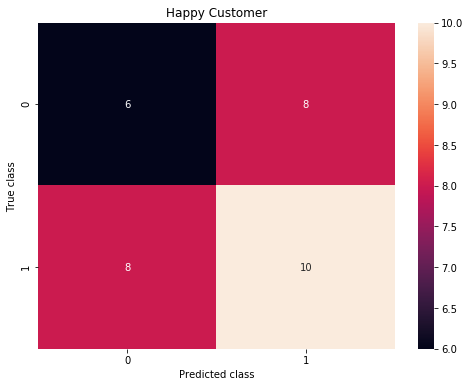

In [23]:
metric_calculation(test_y, pred_y_xgb)

## XGBOOST Model (Without Grid Search) <a class="anchor" id="xgboost-no-grid"></a>

In [24]:
xgb_clf = XGBClassifier(eval_metric='logloss')
xgb_clf.fit(train_X, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [25]:
xgb_clf.score(train_X, train_y)

0.9361702127659575

In [26]:
pred_y_wo_gcv = xgb_clf.predict(test_X)

The accuracy is 0.5625
The precision is 0.6
The recall is 0.6666666666666666
The F1-Score is 0.631578947368421
              precision    recall  f1-score   support

           0       0.50      0.43      0.46        14
           1       0.60      0.67      0.63        18

    accuracy                           0.56        32
   macro avg       0.55      0.55      0.55        32
weighted avg       0.56      0.56      0.56        32



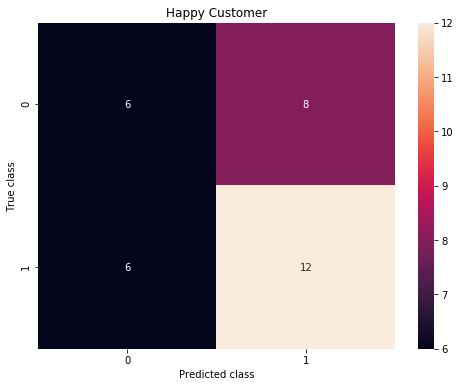

In [27]:
metric_calculation(test_y, pred_y_wo_gcv)

### XGBOOST Model (SHAP Values) <a class="anchor" id="xgboost-shap"></a>

Ref:- 

1. https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values
2. https://blog.dominodatalab.com/shap-lime-python-libraries-part-2-using-shap-lime

In [28]:
# Tree on XGBoost
explainerXGB = shap.TreeExplainer(xgb_clf)
shap_values_XGB_test = explainerXGB.shap_values(test_X)
shap_values_XGB_train = explainerXGB.shap_values(train_X)

In [29]:
shap_values_XGB_train.shape

(94, 6)

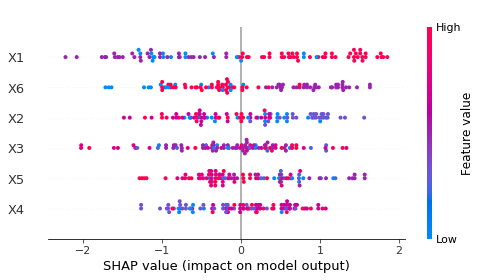

In [30]:
shap.summary_plot(shap_values_XGB_train, train_X)

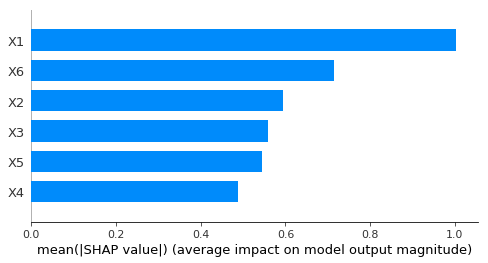

In [31]:
shap.summary_plot(shap_values_XGB_train, train_X, plot_type="bar")

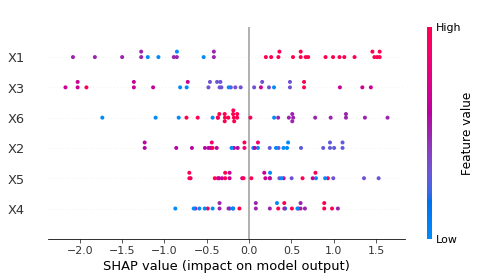

In [32]:
shap.summary_plot(shap_values_XGB_test, test_X)

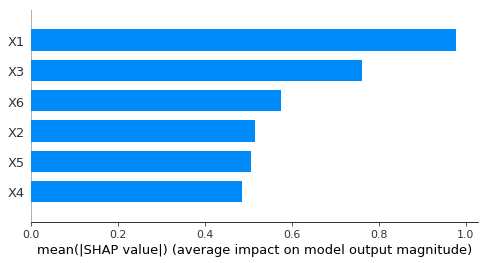

In [33]:
shap.summary_plot(shap_values_XGB_test, test_X, plot_type="bar")

### SHAP Dependence Contribution Plots <a class="anchor" id="xgboost-shap-plot"></a>

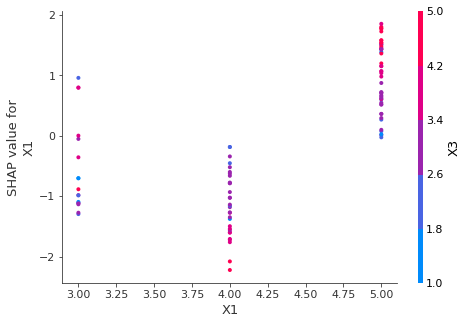

In [34]:
shap.dependence_plot('X1', shap_values_XGB_train, train_X)

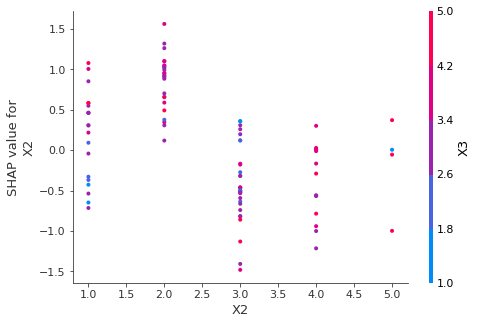

In [35]:
shap.dependence_plot("X2", shap_values_XGB_train, train_X)

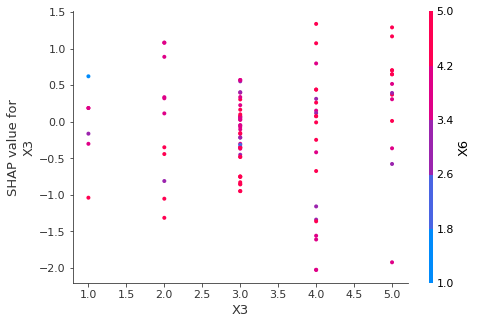

In [36]:
shap.dependence_plot("X3", shap_values_XGB_train, train_X)

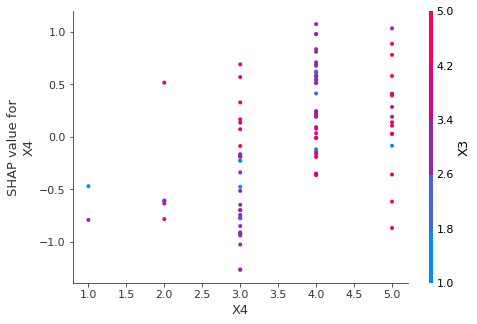

In [37]:
shap.dependence_plot("X4", shap_values_XGB_train, train_X)

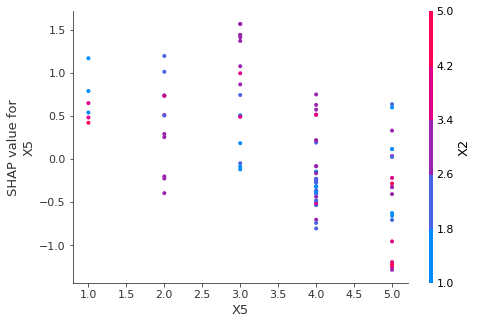

In [38]:
shap.dependence_plot("X5", shap_values_XGB_train, train_X)

## Light GBM <a class="anchor" id="lgbm"></a>

In [39]:
lgbm_clf = LGBMClassifier().fit(train_X, train_y)

In [40]:
lgbm_clf.score(train_X, train_y)

0.6914893617021277

In [41]:
pred_y_lgbm = lgbm_clf.predict(test_X)

The accuracy is 0.71875
The precision is 0.7142857142857143
The recall is 0.8333333333333334
The F1-Score is 0.7692307692307692
              precision    recall  f1-score   support

           0       0.73      0.57      0.64        14
           1       0.71      0.83      0.77        18

    accuracy                           0.72        32
   macro avg       0.72      0.70      0.70        32
weighted avg       0.72      0.72      0.71        32



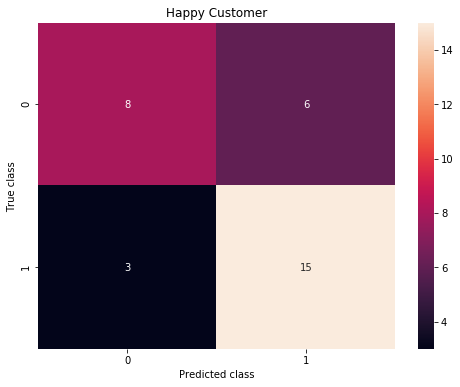

In [42]:
metric_calculation(test_y, pred_y_lgbm)

### LGBM SHAP Values <a class="anchor" id="lgbm-shap"></a>

In [43]:
# Tree on LGBM
explainerLGBM = shap.TreeExplainer(lgbm_clf)
shap_values_LGBM_test = explainerLGBM.shap_values(test_X)
shap_values_LGBM_train = explainerLGBM.shap_values(train_X)

In [44]:
shap_values_LGBM_train[0].shape

(94, 6)

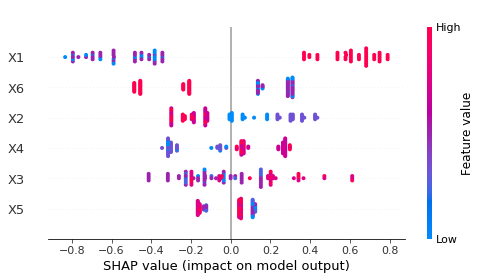

In [45]:
shap.summary_plot(shap_values_LGBM_train[1], train_X)

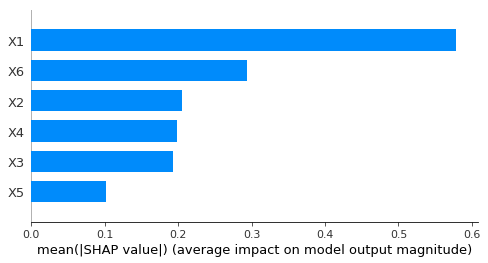

In [46]:
shap.summary_plot(shap_values_LGBM_train[1], train_X, plot_type="bar")

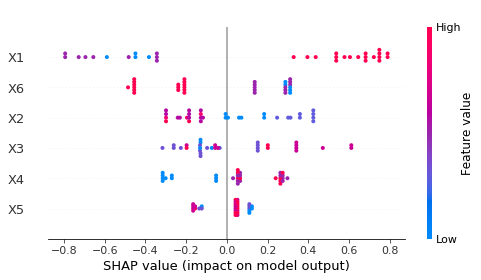

In [47]:
shap.summary_plot(shap_values_LGBM_test[1], test_X)

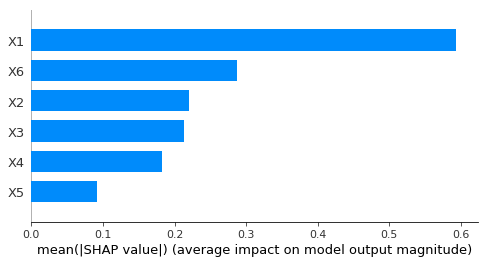

In [48]:
shap.summary_plot(shap_values_LGBM_test[1], test_X, plot_type="bar")

## CatBoost GBM<a class="anchor" id="catboost"></a>

In [49]:
cat_clf = CatBoostClassifier().fit(train_X, train_y)

Learning rate set to 0.003754
0:	learn: 0.6922925	total: 144ms	remaining: 2m 23s
1:	learn: 0.6910589	total: 145ms	remaining: 1m 12s
2:	learn: 0.6908553	total: 146ms	remaining: 48.4s
3:	learn: 0.6902332	total: 147ms	remaining: 36.5s
4:	learn: 0.6893846	total: 147ms	remaining: 29.3s
5:	learn: 0.6890008	total: 148ms	remaining: 24.5s
6:	learn: 0.6879565	total: 149ms	remaining: 21.1s
7:	learn: 0.6871269	total: 150ms	remaining: 18.6s
8:	learn: 0.6865747	total: 151ms	remaining: 16.6s
9:	learn: 0.6860698	total: 152ms	remaining: 15s
10:	learn: 0.6852921	total: 153ms	remaining: 13.8s
11:	learn: 0.6837553	total: 154ms	remaining: 12.7s
12:	learn: 0.6826506	total: 155ms	remaining: 11.8s
13:	learn: 0.6824493	total: 156ms	remaining: 11s
14:	learn: 0.6813285	total: 157ms	remaining: 10.3s
15:	learn: 0.6801628	total: 158ms	remaining: 9.72s
16:	learn: 0.6784527	total: 159ms	remaining: 9.19s
17:	learn: 0.6774265	total: 160ms	remaining: 8.72s
18:	learn: 0.6763500	total: 161ms	remaining: 8.33s
19:	learn: 0.

188:	learn: 0.5651184	total: 326ms	remaining: 1.4s
189:	learn: 0.5644484	total: 327ms	remaining: 1.39s
190:	learn: 0.5639654	total: 328ms	remaining: 1.39s
191:	learn: 0.5632884	total: 329ms	remaining: 1.38s
192:	learn: 0.5626105	total: 330ms	remaining: 1.38s
193:	learn: 0.5617951	total: 331ms	remaining: 1.38s
194:	learn: 0.5611479	total: 332ms	remaining: 1.37s
195:	learn: 0.5608390	total: 333ms	remaining: 1.37s
196:	learn: 0.5602971	total: 334ms	remaining: 1.36s
197:	learn: 0.5598837	total: 335ms	remaining: 1.36s
198:	learn: 0.5592357	total: 336ms	remaining: 1.35s
199:	learn: 0.5585189	total: 337ms	remaining: 1.35s
200:	learn: 0.5577969	total: 338ms	remaining: 1.34s
201:	learn: 0.5576552	total: 339ms	remaining: 1.34s
202:	learn: 0.5566318	total: 340ms	remaining: 1.33s
203:	learn: 0.5561650	total: 341ms	remaining: 1.33s
204:	learn: 0.5558020	total: 342ms	remaining: 1.33s
205:	learn: 0.5553125	total: 343ms	remaining: 1.32s
206:	learn: 0.5545714	total: 344ms	remaining: 1.32s
207:	learn: 0

349:	learn: 0.4942355	total: 483ms	remaining: 896ms
350:	learn: 0.4941290	total: 484ms	remaining: 895ms
351:	learn: 0.4932878	total: 485ms	remaining: 893ms
352:	learn: 0.4925792	total: 486ms	remaining: 891ms
353:	learn: 0.4924767	total: 487ms	remaining: 890ms
354:	learn: 0.4919778	total: 489ms	remaining: 888ms
355:	learn: 0.4917290	total: 490ms	remaining: 886ms
356:	learn: 0.4914887	total: 491ms	remaining: 884ms
357:	learn: 0.4914616	total: 491ms	remaining: 881ms
358:	learn: 0.4911828	total: 493ms	remaining: 880ms
359:	learn: 0.4909774	total: 494ms	remaining: 878ms
360:	learn: 0.4905434	total: 495ms	remaining: 876ms
361:	learn: 0.4903851	total: 496ms	remaining: 874ms
362:	learn: 0.4903593	total: 497ms	remaining: 871ms
363:	learn: 0.4901400	total: 498ms	remaining: 870ms
364:	learn: 0.4897078	total: 499ms	remaining: 868ms
365:	learn: 0.4894812	total: 500ms	remaining: 866ms
366:	learn: 0.4894705	total: 501ms	remaining: 864ms
367:	learn: 0.4889270	total: 502ms	remaining: 862ms
368:	learn: 

652:	learn: 0.4035428	total: 799ms	remaining: 425ms
653:	learn: 0.4032214	total: 800ms	remaining: 423ms
654:	learn: 0.4028813	total: 801ms	remaining: 422ms
655:	learn: 0.4024739	total: 802ms	remaining: 421ms
656:	learn: 0.4022502	total: 803ms	remaining: 419ms
657:	learn: 0.4019277	total: 804ms	remaining: 418ms
658:	learn: 0.4016281	total: 805ms	remaining: 417ms
659:	learn: 0.4014382	total: 807ms	remaining: 416ms
660:	learn: 0.4010311	total: 808ms	remaining: 414ms
661:	learn: 0.4007523	total: 809ms	remaining: 413ms
662:	learn: 0.4005623	total: 810ms	remaining: 412ms
663:	learn: 0.4005569	total: 811ms	remaining: 410ms
664:	learn: 0.4004493	total: 812ms	remaining: 409ms
665:	learn: 0.3999662	total: 813ms	remaining: 408ms
666:	learn: 0.3996486	total: 814ms	remaining: 406ms
667:	learn: 0.3993483	total: 815ms	remaining: 405ms
668:	learn: 0.3991626	total: 816ms	remaining: 404ms
669:	learn: 0.3990899	total: 817ms	remaining: 402ms
670:	learn: 0.3989234	total: 818ms	remaining: 401ms
671:	learn: 

895:	learn: 0.3561990	total: 1.1s	remaining: 128ms
896:	learn: 0.3561653	total: 1.1s	remaining: 127ms
897:	learn: 0.3561140	total: 1.1s	remaining: 126ms
898:	learn: 0.3559586	total: 1.11s	remaining: 124ms
899:	learn: 0.3559274	total: 1.11s	remaining: 123ms
900:	learn: 0.3557966	total: 1.11s	remaining: 122ms
901:	learn: 0.3555381	total: 1.11s	remaining: 121ms
902:	learn: 0.3554002	total: 1.11s	remaining: 119ms
903:	learn: 0.3552345	total: 1.11s	remaining: 118ms
904:	learn: 0.3549981	total: 1.11s	remaining: 117ms
905:	learn: 0.3547208	total: 1.12s	remaining: 116ms
906:	learn: 0.3545496	total: 1.12s	remaining: 115ms
907:	learn: 0.3542932	total: 1.12s	remaining: 113ms
908:	learn: 0.3541431	total: 1.12s	remaining: 112ms
909:	learn: 0.3538234	total: 1.12s	remaining: 111ms
910:	learn: 0.3534599	total: 1.12s	remaining: 110ms
911:	learn: 0.3532683	total: 1.12s	remaining: 109ms
912:	learn: 0.3532200	total: 1.13s	remaining: 107ms
913:	learn: 0.3530189	total: 1.13s	remaining: 106ms
914:	learn: 0.3

In [50]:
cat_clf.score(train_X, train_y)

0.925531914893617

In [51]:
pred_y_cat_clf = cat_clf.predict(test_X)

The accuracy is 0.71875
The precision is 0.7368421052631579
The recall is 0.7777777777777778
The F1-Score is 0.7567567567567567
              precision    recall  f1-score   support

           0       0.69      0.64      0.67        14
           1       0.74      0.78      0.76        18

    accuracy                           0.72        32
   macro avg       0.71      0.71      0.71        32
weighted avg       0.72      0.72      0.72        32



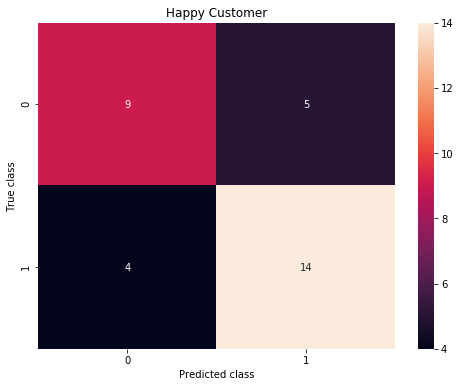

In [52]:
metric_calculation(test_y, pred_y_cat_clf)

### CatBoost SHAP Values <a class="anchor" id="cat-shap"></a>

In [53]:
# Tree on CatBoost
explainerCBM = shap.TreeExplainer(cat_clf)
shap_values_CBM_test = explainerCBM.shap_values(test_X)
shap_values_CBM_train = explainerCBM.shap_values(train_X)

In [54]:
shap_values_CBM_train.shape

(94, 6)

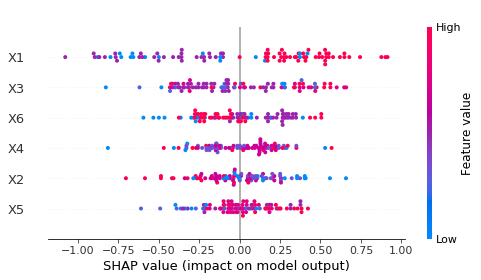

In [55]:
shap.summary_plot(shap_values_CBM_train, train_X)

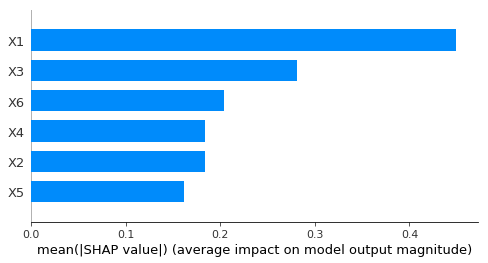

In [56]:
shap.summary_plot(shap_values_CBM_train, train_X, plot_type="bar")

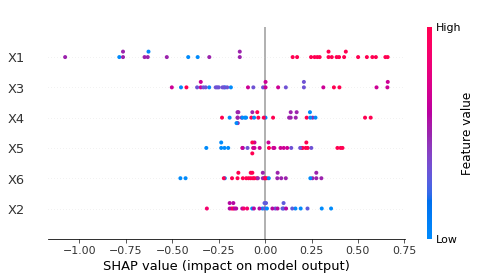

In [57]:
shap.summary_plot(shap_values_CBM_test, test_X)

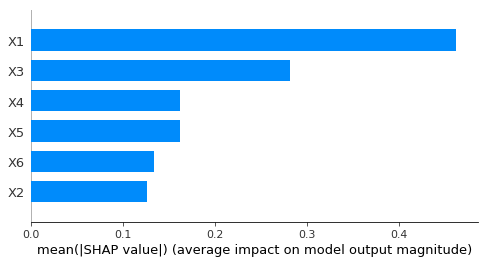

In [58]:
shap.summary_plot(shap_values_CBM_test, test_X, plot_type="bar")

## Feature Selection via RFECV (Recursive Feature Elimination CV) <a class="anchor" id="rfecv"></a>

In [91]:
from sklearn.feature_selection import RFECV

In [92]:
rfe = RFECV(estimator=RandomForestClassifier(), min_features_to_select=4)

In [93]:
rfe.fit(train_X, train_y)

RFECV(estimator=RandomForestClassifier(), min_features_to_select=4)

In [94]:
rfe.support_

array([ True,  True,  True,  True,  True,  True])

In [95]:
train_X.columns[rfe.support_]

Index(['X1', 'X2', 'X3', 'X4', 'X5', 'X6'], dtype='object')

In [96]:
rfe.ranking_

array([1, 1, 1, 1, 1, 1])

In [97]:
train_X_n = train_X.drop(["X3", "X6"], axis=1)

In [98]:
gs_cv.best_estimator_.fit(train_X_n, train_y)

SVC(C=1, kernel='poly')

In [99]:
test_X_n = test_X.drop(["X3", "X6"], axis=1)

In [100]:
pred_y = gs_cv.best_estimator_.predict(test_X_n)

The accuracy is 0.75
The precision is 0.7272727272727273
The recall is 0.8888888888888888
The F1-Score is 0.7999999999999999
              precision    recall  f1-score   support

           0       0.80      0.57      0.67        14
           1       0.73      0.89      0.80        18

    accuracy                           0.75        32
   macro avg       0.76      0.73      0.73        32
weighted avg       0.76      0.75      0.74        32



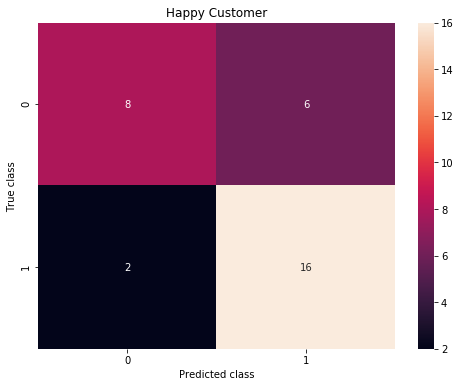

In [101]:
metric_calculation(test_y, pred_y)

## Final Model on selected features <a class="anchor" id="final"></a>

In [70]:
# Dropping feature 'X2' because it holds least importance as per SHAP values of LBGM Classifier

train_X_adj = train_X.drop(['X2'], axis=1)
test_X_adj = test_X.drop(['X2'], axis=1)

In [71]:
train_X_adj

,X1,X3,X4,X5,X6
18,5,2,4,4,5
75,3,3,3,4,4
27,3,1,3,3,4
118,4,3,4,4,4
46,5,3,4,4,5
...,...,...,...,...,...
71,4,5,5,1,3
97,5,5,4,5,4
74,5,5,5,5,5
36,5,4,3,4,5


In [72]:
lgbm_clf = LGBMClassifier()
lgbm_clf.fit(train_X_adj, train_y)

LGBMClassifier()

In [73]:
lgbm_clf.score(train_X_adj, train_y)

0.6808510638297872

In [74]:
pred_y_lgbm = lgbm_clf.predict(test_X_adj)

The accuracy is 0.71875
The precision is 0.6956521739130435
The recall is 0.8888888888888888
The F1-Score is 0.7804878048780488
              precision    recall  f1-score   support

           0       0.78      0.50      0.61        14
           1       0.70      0.89      0.78        18

    accuracy                           0.72        32
   macro avg       0.74      0.69      0.69        32
weighted avg       0.73      0.72      0.71        32



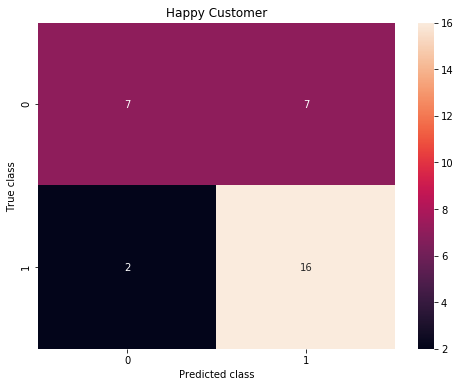

In [75]:
metric_calculation(test_y, pred_y_lgbm)

In [76]:
cat_clf = CatBoostClassifier().fit(train_X_adj, train_y)

Learning rate set to 0.003754
0:	learn: 0.6917046	total: 1.05ms	remaining: 1.05s
1:	learn: 0.6909049	total: 2.58ms	remaining: 1.29s
2:	learn: 0.6898200	total: 4.15ms	remaining: 1.38s
3:	learn: 0.6882212	total: 5.21ms	remaining: 1.3s
4:	learn: 0.6875910	total: 6.07ms	remaining: 1.21s
5:	learn: 0.6862952	total: 6.95ms	remaining: 1.15s
6:	learn: 0.6856528	total: 7.91ms	remaining: 1.12s
7:	learn: 0.6846722	total: 8.95ms	remaining: 1.11s
8:	learn: 0.6839173	total: 9.9ms	remaining: 1.09s
9:	learn: 0.6830642	total: 10.9ms	remaining: 1.08s
10:	learn: 0.6828233	total: 11.7ms	remaining: 1.05s
11:	learn: 0.6817087	total: 12.7ms	remaining: 1.05s
12:	learn: 0.6808390	total: 13.7ms	remaining: 1.04s
13:	learn: 0.6798560	total: 14.7ms	remaining: 1.03s
14:	learn: 0.6790657	total: 15.7ms	remaining: 1.03s
15:	learn: 0.6779472	total: 17.1ms	remaining: 1.05s
16:	learn: 0.6773015	total: 18ms	remaining: 1.04s
17:	learn: 0.6757181	total: 19ms	remaining: 1.04s
18:	learn: 0.6740646	total: 20ms	remaining: 1.03s


234:	learn: 0.5460813	total: 290ms	remaining: 942ms
235:	learn: 0.5453922	total: 291ms	remaining: 941ms
236:	learn: 0.5453670	total: 292ms	remaining: 939ms
237:	learn: 0.5450716	total: 293ms	remaining: 938ms
238:	learn: 0.5449495	total: 294ms	remaining: 937ms
239:	learn: 0.5445303	total: 296ms	remaining: 936ms
240:	learn: 0.5441922	total: 297ms	remaining: 935ms
241:	learn: 0.5435720	total: 299ms	remaining: 935ms
242:	learn: 0.5428533	total: 300ms	remaining: 934ms
243:	learn: 0.5427072	total: 301ms	remaining: 932ms
244:	learn: 0.5426049	total: 302ms	remaining: 930ms
245:	learn: 0.5422350	total: 303ms	remaining: 929ms
246:	learn: 0.5419947	total: 304ms	remaining: 928ms
247:	learn: 0.5417049	total: 305ms	remaining: 926ms
248:	learn: 0.5415716	total: 307ms	remaining: 926ms
249:	learn: 0.5410068	total: 308ms	remaining: 925ms
250:	learn: 0.5402538	total: 309ms	remaining: 924ms
251:	learn: 0.5398047	total: 311ms	remaining: 922ms
252:	learn: 0.5392841	total: 312ms	remaining: 921ms
253:	learn: 

522:	learn: 0.4528396	total: 600ms	remaining: 547ms
523:	learn: 0.4525497	total: 601ms	remaining: 546ms
524:	learn: 0.4524596	total: 601ms	remaining: 544ms
525:	learn: 0.4522818	total: 603ms	remaining: 543ms
526:	learn: 0.4521881	total: 604ms	remaining: 542ms
527:	learn: 0.4516698	total: 605ms	remaining: 541ms
528:	learn: 0.4515548	total: 606ms	remaining: 540ms
529:	learn: 0.4514598	total: 607ms	remaining: 538ms
530:	learn: 0.4514449	total: 608ms	remaining: 537ms
531:	learn: 0.4511543	total: 609ms	remaining: 536ms
532:	learn: 0.4508626	total: 610ms	remaining: 534ms
533:	learn: 0.4501547	total: 611ms	remaining: 533ms
534:	learn: 0.4499221	total: 612ms	remaining: 532ms
535:	learn: 0.4494136	total: 613ms	remaining: 531ms
536:	learn: 0.4491036	total: 614ms	remaining: 530ms
537:	learn: 0.4490523	total: 615ms	remaining: 528ms
538:	learn: 0.4489674	total: 616ms	remaining: 527ms
539:	learn: 0.4487015	total: 617ms	remaining: 526ms
540:	learn: 0.4485741	total: 619ms	remaining: 525ms
541:	learn: 

747:	learn: 0.4093569	total: 897ms	remaining: 302ms
748:	learn: 0.4090952	total: 899ms	remaining: 301ms
749:	learn: 0.4088792	total: 900ms	remaining: 300ms
750:	learn: 0.4088452	total: 901ms	remaining: 299ms
751:	learn: 0.4086645	total: 904ms	remaining: 298ms
752:	learn: 0.4084610	total: 906ms	remaining: 297ms
753:	learn: 0.4082256	total: 907ms	remaining: 296ms
754:	learn: 0.4082142	total: 909ms	remaining: 295ms
755:	learn: 0.4081776	total: 910ms	remaining: 294ms
756:	learn: 0.4081125	total: 911ms	remaining: 292ms
757:	learn: 0.4079696	total: 912ms	remaining: 291ms
758:	learn: 0.4077585	total: 913ms	remaining: 290ms
759:	learn: 0.4076647	total: 914ms	remaining: 289ms
760:	learn: 0.4075123	total: 915ms	remaining: 287ms
761:	learn: 0.4072847	total: 917ms	remaining: 286ms
762:	learn: 0.4071130	total: 918ms	remaining: 285ms
763:	learn: 0.4069925	total: 919ms	remaining: 284ms
764:	learn: 0.4068612	total: 920ms	remaining: 283ms
765:	learn: 0.4067842	total: 921ms	remaining: 281ms
766:	learn: 

In [77]:
cat_clf.score(train_X_adj, train_y)

0.8829787234042553

**There is a decrease in training accuracy from 91% to 88% after dropping feature `X2` which is good because it is reducing the overfitting effect from our previous CatBoost Model**

In [78]:
pred_y_cat_clf = cat_clf.predict(test_X_adj)

The accuracy is 0.78125
The precision is 0.7619047619047619
The recall is 0.8888888888888888
The F1-Score is 0.8205128205128205
              precision    recall  f1-score   support

           0       0.82      0.64      0.72        14
           1       0.76      0.89      0.82        18

    accuracy                           0.78        32
   macro avg       0.79      0.77      0.77        32
weighted avg       0.79      0.78      0.78        32



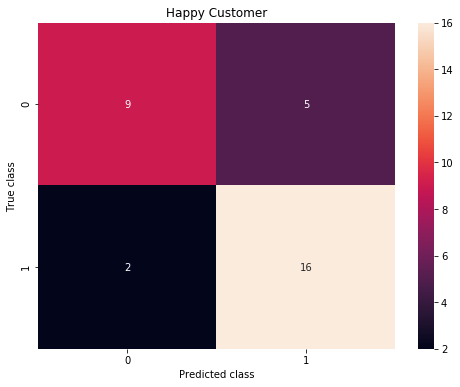

In [79]:
metric_calculation(test_y, pred_y_cat_clf)

## Conclusion <a class="anchor" id="conclusion"></a>

**`Insights from modelling the above data are:`**
1. Using stratification in train_test_split function helped to achieve good acuracy both train and test sets.
2. Polynomial SVC is able to achieve an accuracy of `75%` on test dataset by removing two features from the dataset which are:
    * `X3` = I ordered everything I wanted to order
    * `X6` = the app makes ordering easy for me
3. Boosting algorithms are also performing well in this small dataset. It can be seen from above cells that LightGBM and CatBoost are performing well. 
4. CatBoost, however, is beating LightGBM and XGBoost because it is especially designed to deal with the dataset having categorical features which is the case in this dataset.
5. CatBoost is able to achieve an accuracy on test dataset of `78%` which meets the target criteria for this problem. It achieved this accuracy by dropping a feature:
    * `X2` = contents of my order was as I expected
6. THis concludes that from next surveys this feature (`X2`) can be removed and other feature would be able to preserve most of the information about the problem while increasing predictability of the data.